In [1]:
import pandas as pd 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [19]:
sample_feature=reduce_mem_usage(pd.read_csv('data/data_for_tree.csv'))  

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [31]:
continous_faeture_names=[x for x in sample_feature.columns if x not in ['price'
,'brand','model']]
continous_faeture_names 

['bodyType',
 'fuelType',
 'gearbox',
 'kilometer',
 'name',
 'notRepairedDamage',
 'offerType',
 'power',
 'seller',
 'train',
 'v_0',
 'v_1',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'used_time',
 'city',
 'brand_amount',
 'brand_price_max',
 'brand_price_median',
 'brand_price_min',
 'brand_price_sum',
 'brand_price_std',
 'brand_price_average',
 'power_bin',
 'SaleID']

## 线性回归


In [21]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer


def missing_implute_rf(X_missing, y):
    """
    X_missing: feature columns 
    y: target
    """

    sortindex = np.argsort(X_missing.isnull().sum(axis=0)).values

    for i in sortindex:

        # Construct new feature matrix and new labels
        df = X_missing
        if df.iloc[:, i].isnull().sum() > 0:
            fillc = df.iloc[:, i]
            df = pd.concat(
                [df.iloc[:, df.columns != df.columns[i]], pd.DataFrame(y)], axis=1)
            # Filling columns with missing values with 0 in new feature matrix
            df_0 = SimpleImputer(missing_values=np.nan,
                                 strategy='constant', fill_value=0).fit_transform(df)
            # New train datesets and test datasets
            Y_train = fillc[fillc.notnull()]
            Y_test = fillc[fillc.isnull()]
            X_train = df_0[Y_train.index, :]
            X_test = df_0[Y_test.index, :]
            # Filling missing values with random forest regression
            rfc = RandomForestRegressor(n_estimators=5)
            rfc = rfc.fit(X_train, Y_train)
            Y_predict = rfc.predict(X_test)
            # Add the filled features to the original feature matrix
            X_missing.loc[X_missing.iloc[:, i].isnull(
            ), X_missing.columns[i]] = Y_predict
    return pd.concat([X_missing, pd.DataFrame(y)], axis=1) 

In [26]:
sample_feature=sample_feature.replace('-',np.nan).reset_index(drop=True)
sample_feature['notRepairedDamage']=sample_feature['notRepairedDamage'].astype(np.float32)

In [27]:
sample_feature=missing_implute_rf(sample_feature.iloc[:,1:],sample_feature.iloc[:,0])
(sample_feature.isnull().sum()/len(sample_feature)).sort_values()  

bodyType               0.0
v_3                    0.0
v_4                    0.0
v_5                    0.0
v_6                    0.0
v_7                    0.0
v_8                    0.0
v_9                    0.0
v_2                    0.0
used_time              0.0
brand_amount           0.0
brand_price_max        0.0
brand_price_median     0.0
brand_price_min        0.0
brand_price_sum        0.0
brand_price_std        0.0
brand_price_average    0.0
city                   0.0
power_bin              0.0
v_14                   0.0
v_12                   0.0
brand                  0.0
fuelType               0.0
gearbox                0.0
kilometer              0.0
model                  0.0
name                   0.0
notRepairedDamage      0.0
v_13                   0.0
offerType              0.0
price                  0.0
seller                 0.0
train                  0.0
v_0                    0.0
v_1                    0.0
v_10                   0.0
v_11                   0.0
p

In [48]:
train = sample_feature[continous_faeture_names + ['price']]
train_X = train[continous_faeture_names]
train_y = train['price']     

In [49]:
train_y=np.log(train_y+1) 

In [50]:
# 简单建模
from sklearn.linear_model import LinearRegression 

model=LinearRegression(normalize=True)
model=model.fit(train_X,train_y) 

In [52]:
# 查看训练的回归模型的截距(intercept)与权重(coef)
'intercept: '+str(model.intercept_) 
sorted(dict(zip(continous_faeture_names,model.coef_)).items(),key=lambda x:x[1],reverse=True)

[('v_9', 3.044589571841071),
 ('v_1', 1.71378657311765),
 ('v_2', 1.5312209615564742),
 ('v_13', 0.2635938262152489),
 ('seller', 0.09096111762004926),
 ('v_14', 0.04788703247086514),
 ('gearbox', 0.019024187998273982),
 ('power_bin', 0.009282685031097812),
 ('bodyType', 0.0055455421359774295),
 ('brand_price_min', 5.883356201265898e-05),
 ('brand_price_average', 1.1998178302891082e-05),
 ('used_time', 5.121619595542705e-06),
 ('brand_amount', 1.467115045814415e-06),
 ('brand_price_max', 8.695965584041339e-07),
 ('SaleID', 2.441381692894249e-08),
 ('brand_price_sum', -8.096716823155635e-11),
 ('offerType', -4.920366336591542e-10),
 ('name', -4.696657694563462e-08),
 ('brand_price_std', -3.2298331562338526e-06),
 ('power', -6.662809697059917e-06),
 ('brand_price_median', -1.0840097194210518e-05),
 ('fuelType', -0.0014688103019535575),
 ('city', -0.002208218462830444),
 ('kilometer', -0.008623264087963585),
 ('v_0', -0.018995568244389003),
 ('train', -0.04194944850487247),
 ('notRepaired

In [53]:
import  matplotlib.pyplot as plt  
import seaborn as sns
%matplotlib inline 
sns.set_style('white') 

In [54]:
subsample_index=np.random.randint(0,len(train_y),size=50) 

The predicted price is obvious different from true price


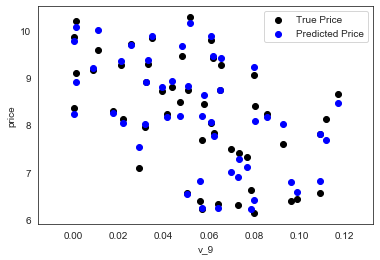

In [55]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()   

It is clear to see the price shows a typical exponential distribution


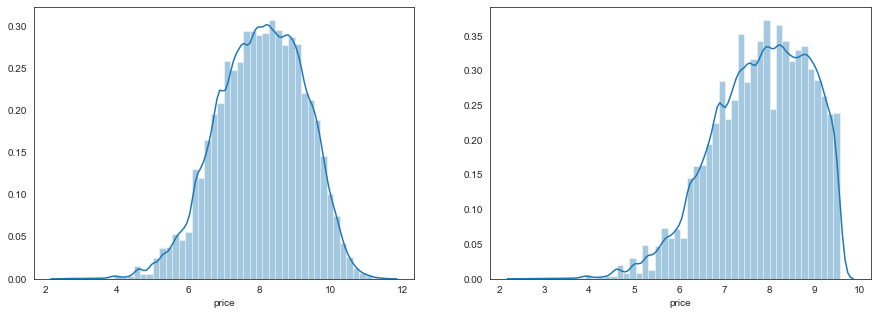

In [56]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])    

In [58]:
# 五折交叉验证
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_absolute_error,make_scorer 

In [63]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [64]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [65]:
# 使用线性回归模型，对未处理标签的特征数据进行五折交叉验证
print('AVG: ',np.mean(scores))

AVG:  0.023923419901777425


In [66]:
# 使用线性回归对处理过标签的特征数据进行五折交叉验证
scores=cross_val_score(model,X=train_X,y=train_y,verbose=1,cv=5,scoring=make_scorer(mean_absolute_error))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [67]:
print("AVG: ",np.mean(scores))

AVG:  0.18248829237452804


In [70]:
# scores=pd.DataFrame(scores.reshape(1,-1))
# scores.columns=['cv'+str(x) for x in range(1,6)]
# scores.index=['MAE']
scores 

,cv1,cv2,cv3,cv4,cv5
MAE,0.191024,0.192238,0.189023,0.183087,0.15707


## 3 模拟真实业务情况

但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大

In [72]:
import datetime

In [73]:
sample_feature=sample_feature.reset_index(drop=True)
split_point=len(sample_feature)//5 *4

In [79]:
train=sample_feature.loc[:split_point].dropna() 
val=sample_feature.loc[split_point:].dropna()

train_X=train[continous_faeture_names]
train_y_l=np.log(train['price']+1)
val_x=val[continous_faeture_names]
val_y=np.log(val['price']+1)  

In [83]:
model=model.fit(train_X,train_y_l)
mean_absolute_error(val_y,model.predict(val_x))

0.15708136411207516

In [84]:
# 绘制学习率曲线
from sklearn.model_selection import learning_curve,validation_curve
?learning_curve 

In [85]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt   

<module 'matplotlib.pyplot' from '/Users/sampras/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

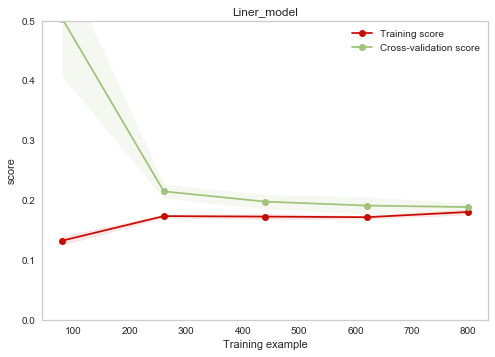

In [93]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_l[:1000], ylim=
                    (0.0, 0.5), cv=5, n_jobs=1)   

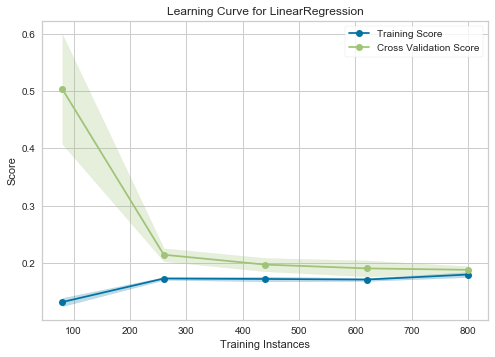

In [109]:
# 可视化模型训练分数与交叉验证测试分数的关系
from yellowbrick.model_selection import LearningCurve

viz = LearningCurve(LinearRegression(),
                      param_name="max_depth",
                      param_range=np.arange(1, 11),
                      cv=5,
                      scoring=make_scorer(mean_absolute_error),n_jobs=1)

# Fit and poof the visualizer
viz.fit(train_X[:1000],train_y_l[:1000])
viz.poof() 

In [101]:
# 多种模型对比
# 线性模型 & 嵌入式特征选择

在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。而嵌入式特征选择在学习器训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。  

In [102]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge

models=[LinearRegression(),Ridge(),Lasso()]

In [112]:
result=dict()
for model in models:
    model_name=str(model).split('(')[0]
    scores=cross_val_score(model,X=train_X,y=train_y_l,
                           verbose=10,
                           cv=5,
                           scoring=make_scorer(mean_absolute_error))
    result[model_name]=scores
    print(model_name+' is finished')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.192, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.193, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.193, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] .................................... , score=0.192, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.182, total=   0.1s
LinearRegression is finished
[CV]  ................................................................
[CV] .................................... , score=0.195, total=   0.1s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.196, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.196, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... , score=0.195, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.186, total=   0.1s
Ridge is finished
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.450, total=   2.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] .................................... , score=0.450, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] .................................... , score=0.448, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV] .................................... , score=0.441, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s


[CV] .................................... , score=0.430, total=   0.8s
Lasso is finished


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.1s finished


In [113]:
# 三种方法效果对比
result=pd.DataFrame(result)
result.index=['cv'+str(x) for x in range(1,6)]
result  

,LinearRegression,Ridge,Lasso
cv1,0.192340,0.194908,0.450357
cv2,0.193093,0.195895,0.450403
cv3,0.193228,0.195840,0.447689
cv4,0.191755,0.194788,0.441043
cv5,0.182377,0.185525,0.430096


intercept:24.802396497180077


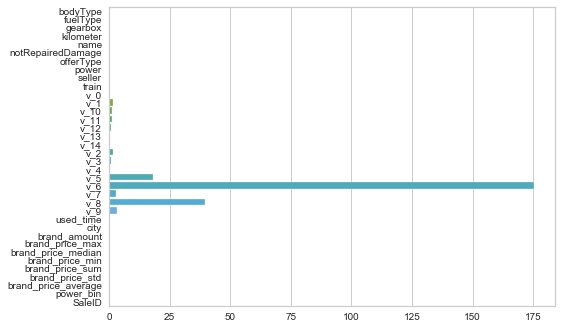

In [120]:
model = LinearRegression().fit(train_X, train_y_l)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continous_faeture_names)   

L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』

intercept:24.802396497180077


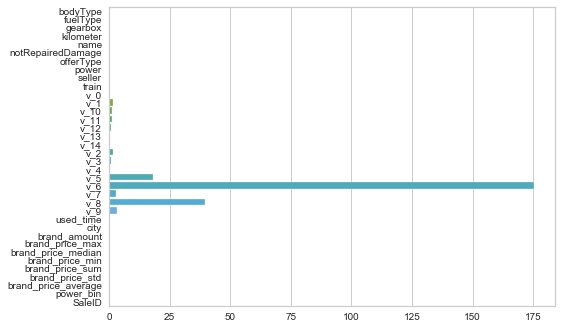

In [122]:
mdoel=Ridge().fit(train_X,train_y_l)
print('intercept:' +str(model.intercept_))
sns.barplot(abs(model.coef_),continous_faeture_names) 


L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择 

intercept:9.04655077769708


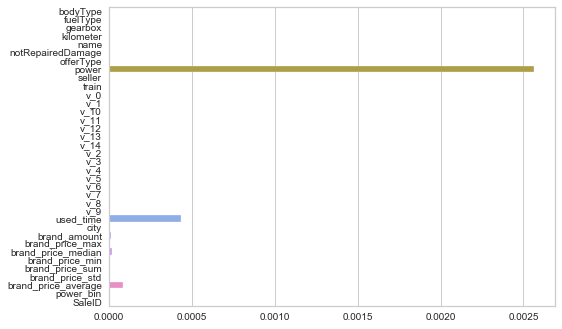

In [124]:
model=Lasso().fit(train_X,train_y_l)
print('intercept:' +str(model.intercept_))
sns.barplot(abs(model.coef_),continous_faeture_names)

除此之外，决策树通过信息熵或GINI指数选择分裂节点时，优先选择的分裂特征也更加重要，这同样是一种特征选择的方法。XGBoost与LightGBM模型中的model_importance指标正是基于此计算的 

In [133]:
# 非线性模型
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor 
from lightgbm.sklearn import LGBMRegressor  

In [134]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]   

In [ ]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_l, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')
    
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result  

LinearRegression is finished
DecisionTreeRegressor is finished


## 模型调参

在此我们介绍了三种常用的调参方法如下：

贪心算法 https://www.jianshu.com/p/ab89df9759c8

网格调参 https://blog.csdn.net/weixin_43172660/article/details/83032029

贝叶斯调参 https://blog.csdn.net/linxid/article/details/81189154